## Preprocessing Phase
This is a notebook in which we discuss all of our preliminary phases. In particular, we put the focus on:
- **Noise Filter** -> Here, we test some coefficient of filters in order to reduce noise in the original dataset
- **Feature Extraction** -> Here, we perform FFT and we extract features, obtaining a new dataset. We take here a sort of exploratory data analysis on this ones, in particular for checking NaN values
- **Redundancy Check** -> Here, we look for highly correlated features, due to the high number of values we extract

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sys
sys.path.append("creation_functions")
from creation_functions.utilities import get_some_filter

In [2]:
raw_dataset = pd.read_csv("processed_dataset/raw_dataset.csv")

### Step 1: Noise Filter
We tested some coefficient of savgol_filter function. We find parameters here, and then we will put the right filter in the _utilities.py_ file. When choosing parameters, we kept focused on the fact that we need to preserve the true peak height, because some signals are better described actually from these heights. For example, action of jogging and walking are better determined if we preserve it.

In [3]:
from scipy.signal import savgol_filter


# Here we have a template for the real function we are putting in .py file
def noise_filter(data, k=10, pol=2):
    dataframe = data.copy()
    for column in dataframe.columns:
        dataframe[column] = savgol_filter(dataframe[column], k, pol, axis=0)
    return dataframe


little_test = get_some_filter(raw_dataset, [5], ["jog"])
little_test = little_test.loc[little_test["trial"] == 9][100:250]
little_test.drop(["subject", "trial", "class"], axis=1, inplace=True)

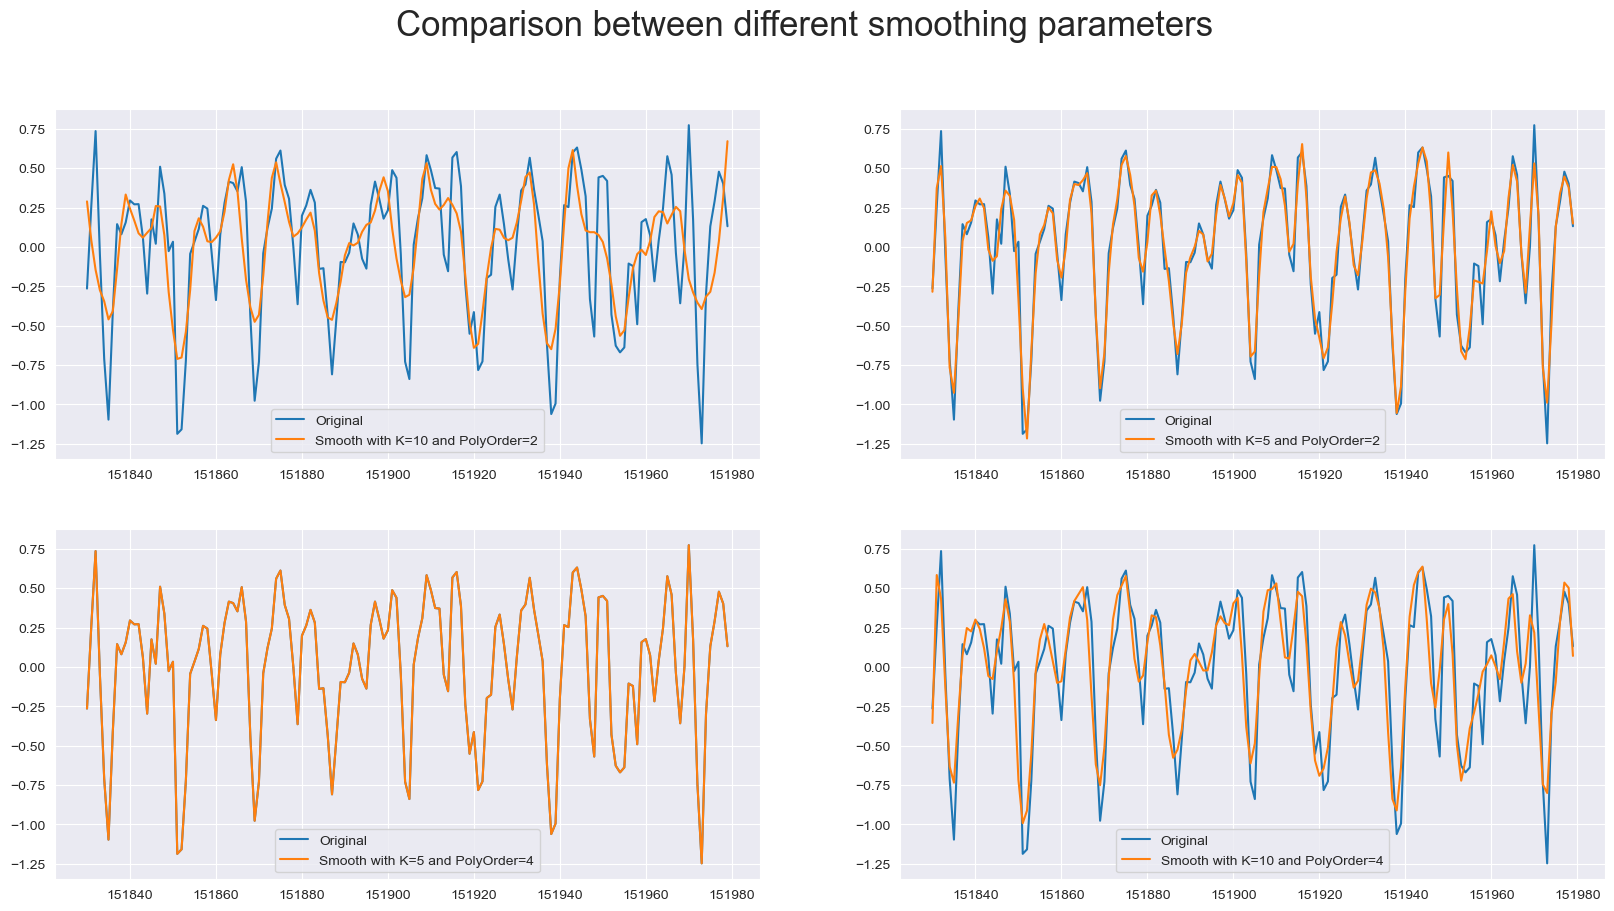

In [4]:
f, axes=plt.subplots(2,2,figsize=(20,10))
f.suptitle("Comparison between different smoothing parameters", fontsize=25)

axes[0][0].plot(little_test["userAcceleration.x"])
axes[0][0].plot(noise_filter(little_test)["userAcceleration.x"])
axes[0][0].legend(["Original", "Smooth with K=10 and PolyOrder=2"])

axes[0][1].plot(little_test["userAcceleration.x"])
axes[0][1].plot(noise_filter(little_test, k=5, pol=2)["userAcceleration.x"])
axes[0][1].legend(["Original", "Smooth with K=5 and PolyOrder=2"])

axes[1][0].plot(little_test["userAcceleration.x"])
axes[1][0].plot(noise_filter(little_test, k=5, pol=4)["userAcceleration.x"])
axes[1][0].legend(["Original", "Smooth with K=5 and PolyOrder=4"])

axes[1][1].plot(little_test["userAcceleration.x"])
axes[1][1].plot(noise_filter(little_test, k=10, pol=4)["userAcceleration.x"])
axes[1][1].legend(["Original", "Smooth with K=10 and PolyOrder=4"])

We decided to have the noise filter with K=5 and PolyOrder=2 because the one with the most reasonable smoothing ratio.

### Step 2: FFT computing and feature extraction.
In this second phase, we use functions _fft_ and _detecta_ to compute fft and its peaks' position and amplitude. During the feature extraction phase, we are going to extract:
- Mean, Std, Kurtosis, Skewness, IQR of all time - domain signals
- First 5 peaks' amplitude and position of all frequency - domain signals

_All functions used for this phase are kept in the _feature_extraction.py_ file_

[Text(0.5, 0, 'Frequency (Hz)'), Text(0, 0.5, 'Amplitude')]

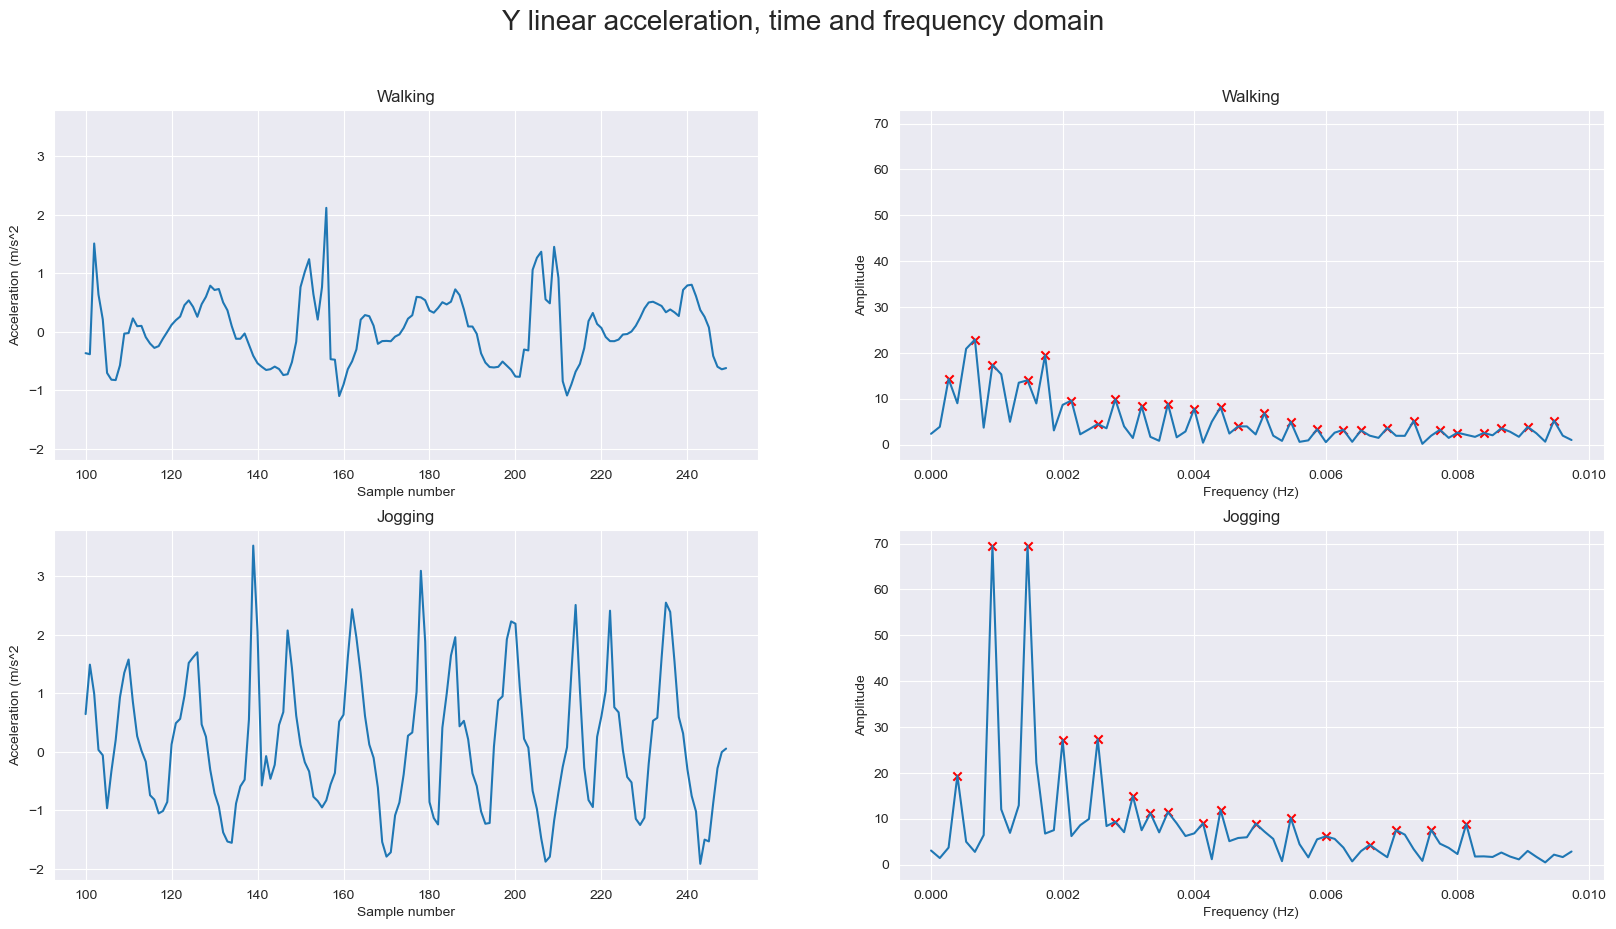

In [5]:
import detecta
from numpy.fft import fft

f,axes=plt.subplots(2,2,figsize=(20,10), sharey="col")

walking_df=pd.read_csv("A_DeviceMotion_data/wlk_7/sub_1.csv")["userAcceleration.y"][100:250]
jogging_df=pd.read_csv("A_DeviceMotion_data/jog_9/sub_1.csv")["userAcceleration.y"][100:250]

f.suptitle("Y linear acceleration, time and frequency domain", fontsize=20)

## TIME DOMAIN ##

axes[0][0].plot(walking_df)
axes[0][0].title.set_text("Walking")
axes[0][0].set(xlabel="Sample number", ylabel="Acceleration (m/s^2")
axes[1][0].plot(jogging_df)
axes[1][0].title.set_text("Jogging")
axes[1][0].set(xlabel="Sample number", ylabel="Acceleration (m/s^2")

## FREQUENCY DOMAIN ##
N=150
n=np.arange(-1,N)
sr=1/50
T=N/sr
freq=n/T
c=20

# FFT computing
n_oneside=N//2
x=freq[1:n_oneside]
y_wlk=np.abs(fft(walking_df)[1:n_oneside])
y_jog=np.abs(fft(jogging_df)[1:n_oneside])

# PEAKS computing
p_x_wlk=detecta.detect_peaks(y_wlk, mph=np.amax(y_wlk)/c)
p_x_jog=detecta.detect_peaks(y_jog, mph=np.amax(y_jog)/c)

#PLOT
axes[0][1].plot(x,y_wlk)
axes[0][1].scatter(p_x_wlk/T, y_wlk[p_x_wlk], marker="x", c="red")
axes[0][1].title.set_text("Walking")
axes[0][1].set(xlabel="Frequency (Hz)", ylabel="Amplitude")
axes[1][1].plot(x,y_jog)
axes[1][1].scatter(p_x_jog/T, y_jog[p_x_jog], marker="x", c="red")
axes[1][1].title.set_text("Jogging")
axes[1][1].set(xlabel="Frequency (Hz)", ylabel="Amplitude")

We can easily see that, taking as example walking and jogging, there are some noticeable differences into the frequency domain. The amplitude of the peaks in particular is different, especially in the first part of the graph. After some time spent in deciding how to extract features in the frequency domain, we decided to take the first 5 peaks in the FFT, both x and y value. This decision was highly supported by some papers that we studied (for example: https://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/)

We have to pay some extra attention to the “detecta” library. In particular the “detect_peaks” function takes an argument, which is min peak height. In this case, in order to not select some useless peaks between the first 5 ones, we started from a high mph=(max of all the values / c) with c=20 and if 5 peaks are not present, then increment c until we have 5. Let’s see an example in which iterating a number of mph is needed.

[Text(0.5, 1.0, 'c=100')]

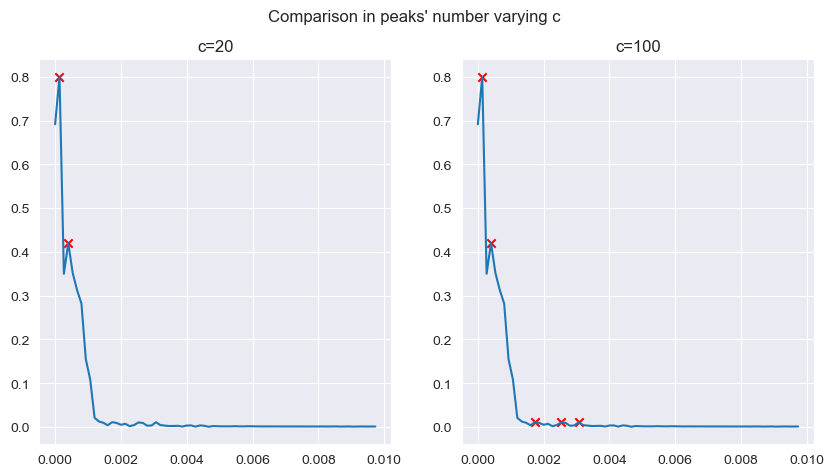

In [6]:
from creation_functions.feature_extraction import noise_filter
df_without_visible_peaks = noise_filter(pd.read_csv("A_DeviceMotion_data/std_6/sub_24.csv"))["gravity.y"][3600:3750]

## FREQUENCY DOMAIN ##
N=150
n=np.arange(-1,N)
sr=1/50
T=N/sr
freq=n/T
c=20

# FFT computing
n_oneside=N//2
x=freq[1:n_oneside]
y_sit=np.abs(fft(df_without_visible_peaks)[1:n_oneside])

f,axes=plt.subplots(1,2,figsize=(10,5))
f.suptitle("Comparison in peaks' number varying c")

# PEAKS computing
p_x_sit_20=detecta.detect_peaks(y_sit, mph=np.amax(y_sit)/c)
c+=70
p_x_sit_30=detecta.detect_peaks(y_sit, mph=np.amax(y_sit)/c)

axes[0].plot(x,y_sit)
axes[0].scatter(p_x_sit_20/T, y_sit[p_x_sit_20], marker="x", c="red")
axes[0].set(title="c=20")

axes[1].plot(x,y_sit)
axes[1].scatter(p_x_sit_30/T, y_sit[p_x_sit_30], marker="x", c="red")
axes[1].set(title="c=100")

There are some cases where the window hasn't 5 peaks, even if c is largely incremented. We opted to substitute the missing peaks' values with null, and to deal with them later.
Due to this problem, a new NaN check is required after feature extraction process

In [7]:
collapsed_dataset = pd.read_csv("processed_dataset/collapsed_dataset.csv")
collapsed_dataset

,gravity.x_mean,gravity.x_std,gravity.x_range,gravity.x_IRQ,gravity.x_kurtosis,gravity.x_skewness,gravity.y_mean,gravity.y_std,gravity.y_range,gravity.y_IRQ,...,userAcceleration.zX#4,userAcceleration.zX#5,userAcceleration.zP#1,userAcceleration.zP#2,userAcceleration.zP#3,userAcceleration.zP#4,userAcceleration.zP#5,class,subject,trial
0,0.660836,0.055586,0.243333,0.065299,-0.262111,-0.253176,0.697236,0.062177,0.300027,0.083480,...,0.001733,0.002133,13.807348,10.305709,10.737154,7.903655,6.034663,dws,1,1
1,0.591719,0.045982,0.182260,0.076077,-0.953223,-0.036783,0.763231,0.049877,0.195841,0.071596,...,0.002133,0.002533,5.954942,11.828021,8.168617,3.514331,6.316686,dws,1,1
2,0.616612,0.050241,0.217641,0.058887,-0.386998,-0.047354,0.765423,0.042016,0.159486,0.060085,...,0.001867,0.002267,4.205105,13.926414,10.132591,7.850723,4.440575,dws,1,1
3,0.819881,0.062960,0.250333,0.052232,0.824574,-1.283976,0.522868,0.095616,0.371295,0.119794,...,0.001333,0.001600,5.260687,5.717704,9.357244,3.591812,3.649510,dws,1,1
4,0.850191,0.031659,0.119984,0.046023,-0.952690,-0.160122,0.480892,0.059932,0.240709,0.076645,...,0.001600,0.001867,7.168658,21.722648,4.473481,7.613701,5.723588,dws,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8877,-0.122797,0.276033,0.808953,0.532103,-1.487179,0.271106,0.918917,0.030907,0.133196,0.040983,...,0.001467,0.001867,8.398322,23.333486,16.774102,19.093016,18.715154,wlk,24,15
8878,-0.074504,0.269702,0.823917,0.509042,-1.412785,0.323312,0.924469,0.036752,0.150159,0.045857,...,0.001467,0.001867,2.715984,28.300697,19.680617,24.616760,20.037615,wlk,24,15
8879,-0.039299,0.269917,0.810115,0.499819,-1.401116,0.319121,0.927167,0.040061,0.148042,0.045022,...,0.001467,0.001867,4.697057,23.213458,15.414131,17.698143,17.489799,wlk,24,15
8880,-0.043965,0.299500,0.915244,0.572758,-1.464768,0.187227,0.910849,0.048021,0.187299,0.063320,...,0.001467,0.001867,8.323046,22.765793,11.518568,18.601501,16.335227,wlk,24,15


Let's take a look at this new collapsed dataset, obtained from windowing the raw dataset.

In [8]:
collapsed_dataset.isna().sum().sort_values(ascending=False)

gravity.zX#5               352
gravity.zP#5               352
gravity.yP#5               338
gravity.yX#5               338
gravity.xX#5               277
                          ... 
rotationRate.z_skewness      0
rotationRate.z_kurtosis      0
rotationRate.z_IRQ           0
rotationRate.z_range         0
trial                        0
Length: 147, dtype: int64

<AxesSubplot:>

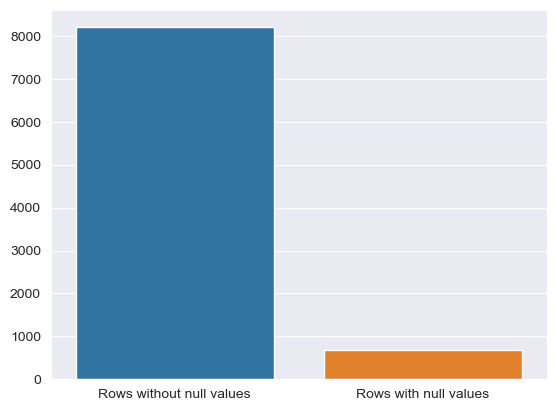

In [9]:
rows_not_null = collapsed_dataset.dropna().shape[0]
rows_null = collapsed_dataset.shape[0]-collapsed_dataset.dropna().shape[0]
sns.barplot(x=["Rows without null values", "Rows with null values"], y=[rows_not_null, rows_null])

About 10% of rows now have null values, introduced by the missing peaks. The majority of them comes from the gravity sensor, which is the one that produces the smoothest signal in frequency. We decided to substitute them with the mean of the attribute of objects belonging to the same class.

In [10]:
collapsed_dataset = collapsed_dataset.fillna(collapsed_dataset.groupby('class').transform('mean'))
collapsed_dataset.isna().sum()

gravity.x_mean           0
gravity.x_std            0
gravity.x_range          0
gravity.x_IRQ            0
gravity.x_kurtosis       0
                        ..
userAcceleration.zP#4    0
userAcceleration.zP#5    0
class                    0
subject                  0
trial                    0
Length: 147, dtype: int64

### Step 3: Redundancy Check
At this point we're interested in discovering if we've introduced some redundancies by selecting these features. To detect that, we use correlation matrix (a matrix in which {ij} element is the pearson correlation factor between feature i and feature j), and we declared redundant the ones with > 95% correlation.

In [11]:
# Create correlation matrix
categorical_labels = collapsed_dataset[["trial", "subject"]]
only_numeric_dataset = collapsed_dataset.drop(["trial", "subject"], axis=1)
corr_matrix = only_numeric_dataset.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# Drop features
to_drop

C:\Users\marco\AppData\Local\Temp\ipykernel_63836\3792515345.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = only_numeric_dataset.corr().abs()


['gravity.x_range',
 'gravity.x_IRQ',
 'gravity.y_range',
 'gravity.y_IRQ',
 'gravity.z_range',
 'gravity.z_IRQ',
 'rotationRate.x_range',
 'rotationRate.x_IRQ',
 'rotationRate.y_range',
 'rotationRate.y_IRQ',
 'rotationRate.z_range',
 'rotationRate.z_IRQ',
 'userAcceleration.x_range',
 'userAcceleration.x_IRQ',
 'userAcceleration.y_range',
 'userAcceleration.y_IRQ',
 'userAcceleration.z_range',
 'userAcceleration.z_IRQ',
 'gravity.yP#1',
 'gravity.zP#1',
 'rotationRate.xP#1']

In [12]:
only_numeric_dataset_uncorrelated = only_numeric_dataset.drop(to_drop, axis=1)

For seeing how much important it has been to remove highly correlated features, let’s perform a primitive feature selection, let’s say a SelectKBeast(k=4), and have a look at the feature selected

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder

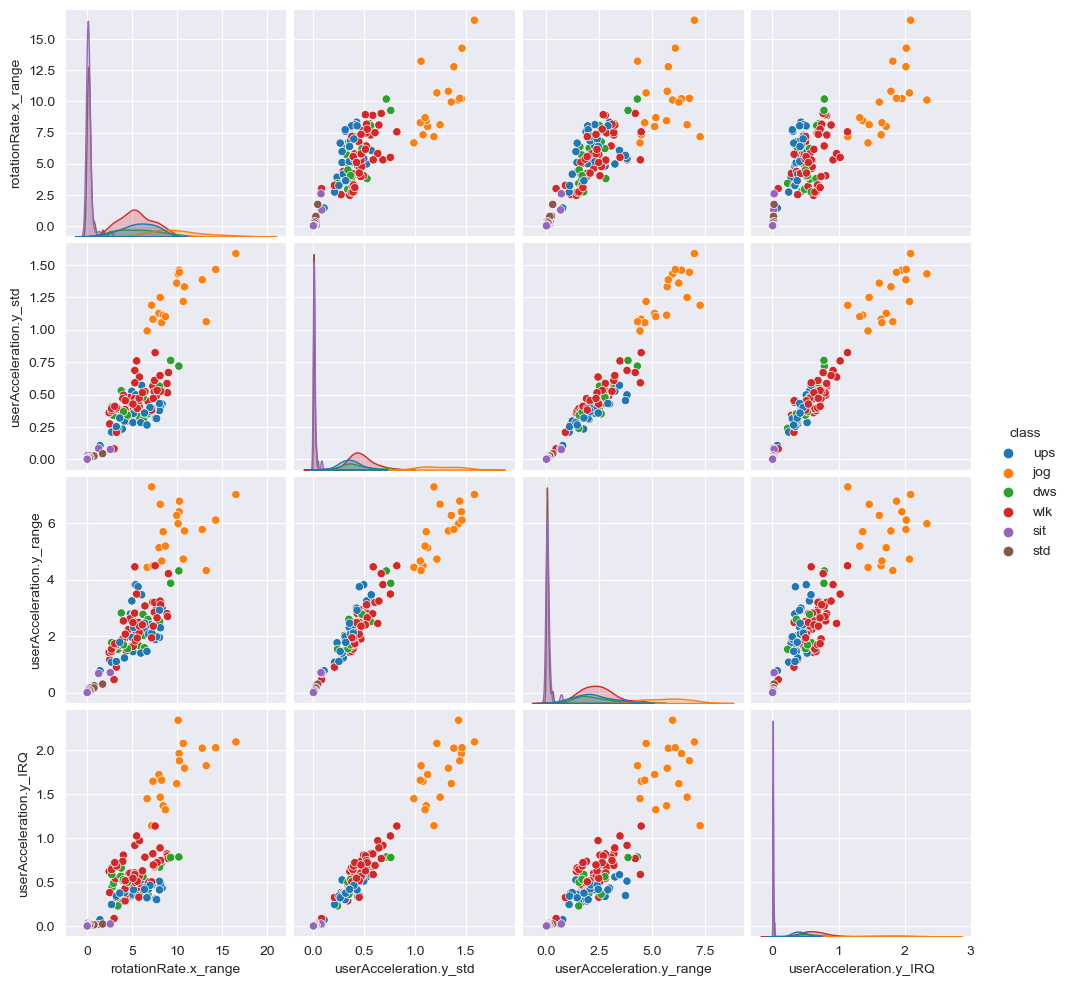

In [14]:
encoder=LabelEncoder()
feature_sel = SelectKBest(k=4).fit(only_numeric_dataset.drop("class", axis=1), encoder.fit_transform(only_numeric_dataset["class"]))
selected_features=feature_sel.get_support(indices=True)
selected_features=np.append(selected_features, 144)

test1 =only_numeric_dataset.iloc[:, selected_features]

sns.pairplot(data=test1.sample(n=200), hue="class")

We can easily notice that userAccelaration.y_std, userAcceleration.y_range, userAcceleration.y_IRQ seem to be highly correlated at a first sight.

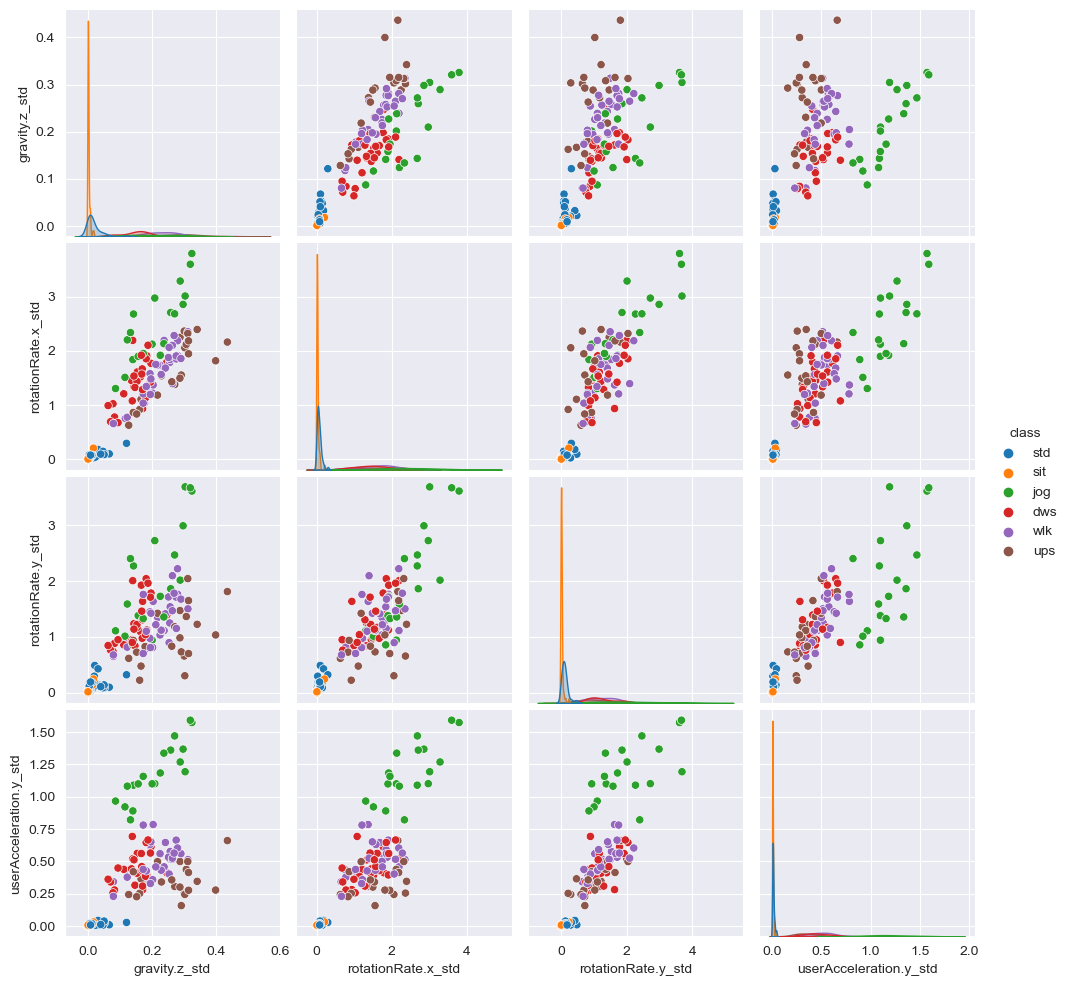

In [15]:
encoder=LabelEncoder()
feature_sel = SelectKBest(k=4).fit(only_numeric_dataset_uncorrelated.drop("class", axis=1), encoder.fit_transform(only_numeric_dataset_uncorrelated["class"]))
selected_features=feature_sel.get_support(indices=True)
selected_features=np.append(selected_features, 123)

test1 =only_numeric_dataset_uncorrelated.iloc[:, selected_features]

sns.pairplot(data=test1.sample(n=200), hue="class")

As we can see, features appear to be more sparse now, and SelectKBest choose more different features.

In [16]:
# Check for duplicates
only_numeric_dataset_uncorrelated = pd.concat([only_numeric_dataset_uncorrelated, categorical_labels], axis=1)
print(only_numeric_dataset_uncorrelated.shape)
dropped = only_numeric_dataset_uncorrelated.drop_duplicates()
print(dropped.shape)

(8882, 126)
(8882, 126)


Now that we discussed feature extraction, we would like to point out the choice of the window's size. Let's take a look at that, by applying the same procedure we adopted here for different sizes. In the **preprocessing** (in utilities.py) we have implemented all steps done until now (check for NaN values and redundancy check). The three datasets _df{3,5,7}secs.csv_ are previously computed with the *create_time_series(mode="Collapsed")* function, which perform the feature extraction step.

In [17]:
from creation_functions.utilities import preprocessing

In [18]:
df_3secs = preprocessing(pd.read_csv("processed_dataset/df_3secs.csv"))
df_5secs = preprocessing(pd.read_csv("processed_dataset/df_5secs.csv"))
df_7secs = preprocessing(pd.read_csv("processed_dataset/df_7secs.csv"))

C:\Users\marco\Desktop\università\magistrale\data mining and machine learning\project_final\LavorettiFinali\creation_functions\utilities.py:86: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = only_numeric_dataset.corr().abs()
C:\Users\marco\Desktop\università\magistrale\data mining and machine learning\project_final\LavorettiFinali\creation_functions\utilities.py:86: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = only_numeric_dataset.corr().abs()
C:\Users\marco\Desktop\università\magistrale\data mining and machine learning\project_final\LavorettiFinali\creation_functions\utilities.py:86: FutureWarning: The default value o

In [20]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

C:\Users\marco\anaconda3\envs\DMML\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marco\anaconda3\envs\DMML\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\marco\anaconda3\envs\DMML\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marco\anaconda3\envs\DMML\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\marco\anaconda3\envs\DMML\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are co

[Text(0.5, 0, 'Window size'),
 Text(0, 0.5, 'Accuracy'),
 Text(0.5, 1.0, "Accuracy when window's size varies")]

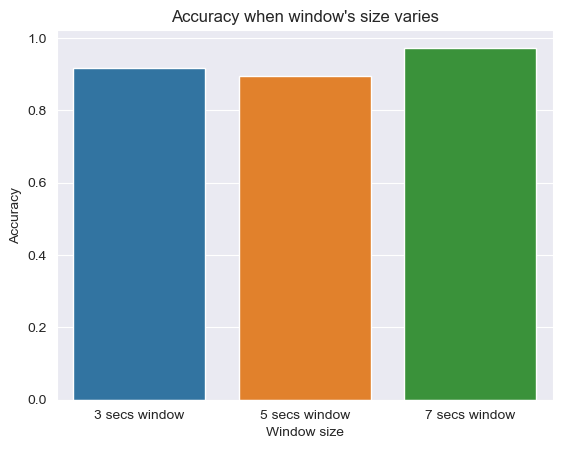

In [21]:
knn_pipe=Pipeline([
    ("scaler", RobustScaler()),
    ("sampling", SMOTE()),
    ("feature-selector", SelectKBest(k=10)),
    ("classifier", KNeighborsClassifier(n_neighbors=5))
])

res_3_secs = np.mean(cross_val_score(knn_pipe, df_3secs.drop("class", axis=1), df_3secs["class"], cv=KFold(5, shuffle=True, random_state=123)))
res_5_secs = np.mean(cross_val_score(knn_pipe, df_5secs.drop("class", axis=1), df_5secs["class"], cv=KFold(5, shuffle=True, random_state=123)))
res_7_secs = np.mean(cross_val_score(knn_pipe, df_7secs.drop("class", axis=1), df_7secs["class"], cv=KFold(5, shuffle=True, random_state=123)))


ax=sns.barplot(x=["3 secs window","5 secs window", "7 secs window"], y=[res_3_secs, res_5_secs, res_7_secs])
ax.set(xlabel="Window size", ylabel="Accuracy", title="Accuracy when window's size varies")

As we can see by expanding the window size we obtain better results in the classification task. It's clear that having more samples in the window means have a higher discriminative power to select the right class for the particular window. We chose anyway to stick with the 3 seconds window size. The reason behind that choice is the fact that we will build an android application on top of the classifier, and so we need the window size to be low, in order to have an high responsiveness in the application.

### Preprocessing ends here
We have learned a bit of information from data in this second phase. In particular:
- We have chosen the number of points of smoothing and the degree of the smoothing function as K = 5 and PolOrder = 2.
- We computed the fft and we find out that some signals don't have 5 peaks, so we implemented a strategy to substitute these NaN values
- We identified there are some feature extracted that are too similar with others. SelectKBest, a feature selector that doesn't care by default at redudancy, select different features it they are first filtered using a correlation index (we used a correlation threshold of 95%)
- We checked for duplicated after all preprocessing steps.
- All operations are then kept in a python function "preprocessing" for the other notebooks